# Module71-80
## 20200921-20200925

1. alibi
1. yellowbrick
1. sklearnplot
1. Eli5
1. LIME
1. pyspark
1. findspark
1. dlib
1. glob
1. cv2

---
## 8.71 dtw

In [3]:
# 样例 二维测试
from dtw import dtw

# Here, we use L2 norm as the element comparison distance
l2_norm = lambda x, y: ((x[0] - y[0]) ** 2 + (x[1] - y[1]) ** 2) ** 0.5

dist, cost_matrix, acc_cost_matrix, path = dtw(x, y, dist=l2_norm)

dist

8.261297173761164

In [72]:
import psycopg2
from dtw import dtw
import numpy as np
from math import radians, cos, sin, asin, sqrt
import folium
from sklearn.cluster import AgglomerativeClustering

# 经纬度距离计算
def geodistance(x, y):
    #lng1,lat1,lng2,lat2 = (120.12802999999997,30.28708,115.86572000000001,28.7427)
    lng1 = x['lon']
    lat1 = x['lat']
    lng2 = y['lon']
    lat2 = y['lat']
    lng1, lat1, lng2, lat2 = map(radians, [float(lng1), float(lat1), float(lng2), float(lat2)]) # 经纬度转换成弧度
    dlon=lng2-lng1
    dlat=lat2-lat1
    a=sin(dlat/2)**2 + cos(lat1) * cos(lat2) * sin(dlon/2)**2 
    distance=2*asin(sqrt(a))*6371*1000 # 地球平均半径，6371km
    distance=round(distance,3)
    return distance

def getData(vin  = 'LL2274099JW110244'):
    conn = psycopg2.connect(database="staging", user="dater", password="q1w2e3r4", host="127.0.0.1", port="5432")
    cur = conn.cursor()
    cur.execute(("""select distinct  time,vin,gps_longitude,gps_latitude
        from public.wm_caninfo_sample20190826
        where vin='%s' and gps_longitude>0
        order by time""") % (vin))
    dat = cur.fetchall()
    conn.commit()
    return(dat)

#dat = getData()
#len(dat)



def devisionData(dat, save = False):
    label = 0
    allDat = []
    tmpDat = []
    dtTable = []
    for i in range(len(dat)):
    #for i in range(100):
        if i!=1 and (dat[i][0] - dat[i-1][0]).seconds >180:
            if tmpDat!=[] and geodistance(tmpDat[0], tmpDat[len(tmpDat)-1])>1000 and  len(tmpDat)>10:
                allDat.append(tmpDat)
            label = label+1
            tmpDat = []
        inDat = {'lon': dat[i][2],
                 'lat': dat[i][3],
                 'label': label,
                 'time':str(dat[i][0])
                }
        dtTable.append([dat[i][2], dat[i][3],label,str(dat[i][0])])
        tmpDat.append(inDat)

        
    print(len(allDat))
    if(save):
        conn = psycopg2.connect(database="staging", user="dater", password="q1w2e3r4", host="127.0.0.1", port="5432")
        cur = conn.cursor()
        cur.execute("drop table tmp_tracesplit")
        cur.execute('''CREATE TABLE tmp_tracesplit
               (lon     float,
                lat             float,
                label            int,
                dtime               TEXT);''')
        conn.commit()
        print("Table created successfully")

        conn = psycopg2.connect(database="staging", user="dater", password="q1w2e3r4", host="127.0.0.1", port="5432")
        cur = conn.cursor()
        sql = 'INSERT INTO tmp_tracesplit values(%s,%s,%s,%s)'
        cur.executemany(sql, dtTable)
        conn.commit()

    #cur.execute("select * from tmp_tracesplit;")
    #cur.fetchmany(5)
    return(allDat)

#dat = getData()
#allDat = devisionData(dat)
#len(allDat)

def trainClusterModel(allDat):

    # print(allDat[1][1])
    # geodistance(allDat[1][1],allDat[1][2])
    # Here, we use L2 norm as the element comparison distance
    # 距离矩阵建立
    outMatrix = []
    tmpArray = []

    for i in range(len(allDat)):
        for j in range(len(allDat)):
            #if j <= i : continue
            #or i==0 or j==0 
            #or len(allDat[i])<=10 or len(allDat[j])<=10 or \
            #geodistance(allDat[i][0], allDat[i][len(allDat[i])-1])<1000 or \
            #geodistance(allDat[j][0], allDat[j][len(allDat[j])-1])<1000 : continue
            dist, cost_matrix, acc_cost_matrix, path = dtw(allDat[i], allDat[j], dist=geodistance)
            tmpArray.append(dist/1000)
            if dist/1000<200 :
                print (i, j, len(allDat[i]), len(allDat[j]), dist)
        outMatrix.append(tmpArray)
        tmpArray = []

    #print(outMatrix)
    
    clustering = AgglomerativeClustering(affinity = 'precomputed',
                                     linkage = 'average',
                                     n_clusters = None,
                                     distance_threshold = 200).fit(outMatrix)
    return(clustering)


def plotMap(lineArray=[ 3, 10, 15, 17, 42, 51], allDat=allDat):
    Map = folium.Map(tiles='http://webrd02.is.autonavi.com/appmaptile?lang=zh_cn&size=1&scale=1&style=7&x={x}&y={y}&z={z}',
              attr='default',
              location=[39.90,116.40],
              zoom_start=11)
    colorList = ['green','blue','skyblue','red','purple','black','green','blue','skyblue','red','purple','black']
    m = 0
    for i in lineArray:
        tmp = allDat[i]
        lineArray=[]
        for j in range(len(tmp)):
            lineArray.append([tmp[j]['lat'],tmp[j]['lon']])
        folium.PolyLine(lineArray,color=colorList[m]).add_to(Map)
        m += 1

    return(Map)

In [5]:
def main(vin):
    dat = getData(vin)
    allDat = devisionData(dat)
    clustering = trainClusterModel(allDat)
    return(clustering,allDat)

In [64]:
(clustering,allDat) = main('LL2274099JW110244')

63
0 0 143 143 0.0
1 1 40 40 0.0
2 2 138 138 0.0
3 3 76 76 0.0
4 4 62 62 0.0
5 5 21 21 0.0
6 6 13 13 0.0
7 7 95 95 0.0
8 8 14 14 0.0
9 9 16 16 0.0
10 10 81 81 0.0
11 11 14 14 0.0
12 12 26 26 0.0
13 13 52 52 0.0
14 14 164 164 0.0
15 15 87 87 0.0
16 16 111 111 0.0
17 17 77 77 0.0
18 18 32 32 0.0
19 19 72 72 0.0
20 20 145 145 0.0
21 21 25 25 0.0
22 22 84 84 0.0
23 23 68 68 0.0
24 24 67 67 0.0
25 25 51 51 0.0
26 26 58 58 0.0
27 27 74 74 0.0
28 28 88 88 0.0
29 29 82 82 0.0
30 30 126 126 0.0
31 31 21 21 0.0
32 32 29 29 0.0
33 33 25 25 0.0
34 34 166 166 0.0
35 35 86 86 0.0
36 36 150 150 0.0
37 37 59 59 0.0
38 38 43 43 0.0
39 39 26 26 0.0
40 40 65 65 0.0
41 41 51 51 0.0
42 42 84 84 0.0
43 43 77 77 0.0
44 44 80 80 0.0
45 45 46 46 0.0
46 46 172 172 0.0
47 47 15 15 0.0
48 48 53 53 0.0
49 49 88 88 0.0
50 50 111 111 0.0
51 51 80 80 0.0
52 52 95 95 0.0
53 53 27 27 0.0
54 54 26 26 0.0
55 55 119 119 0.0
56 56 77 77 0.0
57 57 63 63 0.0
58 58 26 26 0.0
59 59 19 19 0.0
60 60 68 68 0.0
61 61 62 62 0.0
62 

In [58]:
dist, cost_matrix, acc_cost_matrix, path = dtw(allDat[1], allDat[5], dist=geodistance)

In [61]:
dtw(allDat[1], allDat[5], dist=geodistance)

(32491.737999999987,
 array([[   15.79 ,    15.811,    17.934, ..., 10115.904, 10114.943,
         10115.078],
        [   15.348,    15.37 ,    17.63 , ..., 10115.462, 10114.502,
         10114.636],
        [   52.896,    53.062,    37.646, ..., 10106.315, 10105.339,
         10105.468],
        ...,
        [10358.05 , 10358.112, 10355.676, ...,  2704.412,  2701.013,
          2699.834],
        [10631.822, 10631.877, 10630.226, ...,  2262.02 ,  2258.807,
          2257.615],
        [10966.338, 10966.388, 10965.18 , ...,  2115.355,  2112.479,
          2111.314]]),
 array([[1.57900000e+01, 3.16010000e+01, 4.95350000e+01, ...,
         4.57680070e+05, 4.67795013e+05, 4.77910091e+05],
        [3.11380000e+01, 3.11600000e+01, 4.87900000e+01, ...,
         4.57665099e+05, 4.67779601e+05, 4.77894237e+05],
        [8.40340000e+01, 8.42000000e+01, 6.88060000e+01, ...,
         4.54873844e+05, 4.64979183e+05, 4.75084651e+05],
        ...,
        [3.57277781e+05, 3.57277843e+05, 3.56444499

In [81]:
plotMap([31,58], allDat)

In [88]:
plotMap(np.where(clustering.labels_==12)[0], allDat)

In [87]:
np.where(clustering.labels_==12)[0]

array([ 3, 10, 15, 17, 22, 35, 42, 44, 51])

In [84]:
i =31
j = 32
print(allDat[i][0])
print(allDat[j][0])

geodistance(allDat[i][0],allDat[j][0])

{'lon': 116.273888, 'lat': 39.896171, 'label': 75, 'time': '2018-11-24 10:43:58+08:00'}
{'lon': 116.285308, 'lat': 39.859881, 'label': 76, 'time': '2018-11-24 15:08:40+08:00'}


4151.264

In [ ]:
dtw(allDat[31], allDat[32], dist=geodistance)

In [66]:
for i in range(clustering.n_clusters_):
    print(np.where(clustering.labels_==i))
    


(array([ 7, 16, 26, 29, 43, 48, 50, 52]),)
(array([31, 32, 33, 58]),)
(array([ 6, 11, 47, 54, 62]),)
(array([56]),)
(array([18, 38, 39, 59]),)
(array([ 1, 23, 40, 45]),)
(array([ 5, 12]),)
(array([46]),)
(array([34]),)
(array([41, 60]),)
(array([57]),)
(array([49, 61]),)
(array([ 3, 10, 15, 17, 22, 35, 42, 44, 51]),)
(array([ 8,  9, 21, 53]),)
(array([24]),)
(array([0]),)
(array([20]),)
(array([27]),)
(array([4]),)
(array([14]),)
(array([25, 37]),)
(array([36]),)
(array([19]),)
(array([2]),)
(array([55]),)
(array([28]),)
(array([13]),)
(array([30]),)


In [33]:
np.bincount(clustering.labels_)

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1])

In [ ]:
plotMap([22, 35, 44])

In [ ]:
plotMap([7, 26, 43, 52])

## 8.72 pykeyboard

In [ ]:
from pykeyboard import PyKeyboard
k = PyKeyboard()
k.tap_key(k.caps_lock_key,n=1000,interval=200) 
#模拟点击H键，2次，每次间隔5秒 


## 8.73 pymouse

In [ ]:
from pymouse import PyMouse 
import time
myMouse = PyMouse()
nowP = myMouse.position()
print(nowP)
i = 0
while i<1000:
    i+=1
    time.sleep(3)
    nowP = myMouse.position()
    print(nowP)
    myMouse.click(x = 218,y=213,button=1)
    myMouse.click(x = 204,y=243,button=1)

## 8.74 pyinstaller

## 8.75 wxpy

## 8.76 elasticsearch

In [ ]:
# coding: utf-8

# 导入模块
from wxpy import *
from elasticsearch import Elasticsearch

import datetime,threading,time
lockObject = threading.Lock()


# 初始化机器人，扫码登陆
bot = Bot()

es = Elasticsearch("10.60.10.28:9200")


def __len__(self):
    return len(self.names)


def esinto(msgid, msgsender, msgmember, msgtext, num, updateTime):
    data = {
        "updateTime": updateTime * 1000,
        "mediaId": "5000",
        "publishTime": updateTime * 1000,
        "author": msgmember,
        "content": msgtext,
        "id": msgid,
        "title": msgsender,
        "forumName": num
    }
    es.index(index="saas-forum-details-2019", doc_type="details", body=data)

def uptTime():
    global lockObject
    lockObject.acquire()
    t = datetime.datetime.now()
    timeStamp = time.mktime(t.timetuple())
    lockObject.release()
    return timeStamp

def getTodayTimeStamp():
    global lockObject
    lockObject.acquire()
    now = datetime.datetime.now()
    timeStamp = '%s 00:00:00' % now.strftime( '%Y-%m-%d' )
    timeStamp = time.strptime( timeStamp, '%Y-%m-%d %X' )
    timeStamp = int(time.mktime( timeStamp ))
    lockObject.release()

    return timeStamp

# 消息接收监听器
@bot.register()
def print_msg(msg):
    try:
        # 群人数（forumname）
        # num = len(msg.sender.members)
        # forumName
        num = "威马车主群"
        msgid = msg.id
        #群名（标题）
        msgsender = msg.sender.name
        #发消息用户（author）
        msgmember = msg.member.name
        #消息内容（content）
        msgtext = msg.text
        # 更新时间
        updateTime = getTodayTimeStamp()
        if '威马' in msgsender:
            esinto(msgid, msgsender, msgmember, msgtext, num, updateTime)
    except Exception as e:
        print('except:', e)


embed()


## 8.77 qrcode

In [92]:
import qrcode
img = qrcode.make('helloworld')
#带图片的编码方式
qr = qrcode.QRCode(
    version=5,
    error_correction=qrcode.constants.ERROR_CORRECT_H,
    box_size=8,
    border=4)
print(qr)

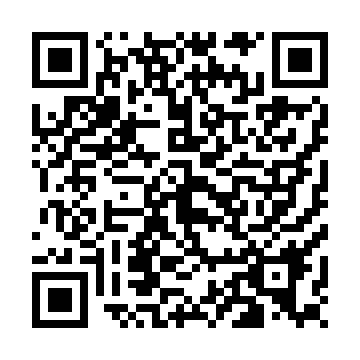

In [95]:
qr.make_image()

## 8.78 PyPDF2

In [97]:
from PyPDF2 import PdfFileReader

def extract_information(pdf_path):
    with open(pdf_path,'rb') as f:
        pdf = PdfFileReader(f)
        information = pdf.getDocumentInfo()
        number_of_pages = pdf.getNumPages()
        
    txt = f"""
    Information about {pdf_path}:
    
    Author:{information.author}
    Creator:{information.creator}
    Producer:{information.producer}
    Subject:{information.subject}
    Title:{information.title}
    Number of pages:{number_of_pages}
    """
    
    print(txt)
    return information


path = r'./data/storytelling-with-data-cole-nussbaumer-knaflic.pdf'
#这是我个人PDF的路径
extract_information(path)


    Information about ./data/storytelling-with-data-cole-nussbaumer-knaflic.pdf:
    
    Author:Cole Nussbaumer Knaflic
    Creator:Adobe InDesign CS4 (6.0)
    Producer:Adobe PDF Library 9.0
    Subject:None
    Title:Storytelling with Data
    Number of pages:284
    


{'/Author': 'Cole Nussbaumer Knaflic',
 '/CreationDate': "D:20151008145533+05'30'",
 '/Creator': 'Adobe InDesign CS4 (6.0)',
 '/ModDate': "D:20151008193107+05'30'",
 '/Producer': 'Adobe PDF Library 9.0',
 '/Title': 'Storytelling with Data',
 '/Trapped': '/False',
 '/EBX_PUBLISHER': '/Wiley'}

In [99]:
# pdf_splitting.py

from PyPDF2 import PdfFileReader, PdfFileWriter

def split(path, name_of_split):
    pdf = PdfFileReader(path)
    for page in range(5):
        pdf_writer = PdfFileWriter()
        pdf_writer.addPage(pdf.getPage(page))

        output = f'{name_of_split}{page}.pdf'
        with open(output, 'wb') as output_pdf:
            pdf_writer.write(output_pdf)


path = r'./data/storytelling-with-data-cole-nussbaumer-knaflic.pdf'
split(path, './data/jupyter_page')

## 8.79 easyOCR

In [110]:
import easyocr
reader = easyocr.Reader(['ch_sim','en']) # need to run only once to load model into memory
result = reader.readtext('./data/example2.png')

CUDA not available - defaulting to CPU. Note: This module is much faster with a GPU.


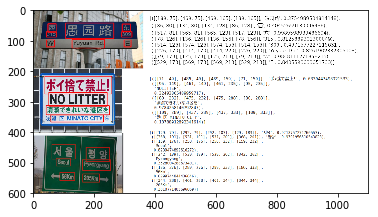

In [114]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg 
plt.imshow(mpimg.imread('./data/example2.png'))

In [111]:
result

[([[380, 14], [812, 14], [812, 40], [380, 40]],
  "[([[189, 75], [469, 75], [469, 165], [189, 165]],'愚园路'",
  0.002910847309976816),
 ([[819, 17], [1007, 17], [1007, 37], [819, 37]],
  '0.3754989504814148),',
  0.2510387897491455),
 ([[386, 40], [730, 40], [730, 64], [386, 64]],
  '([[86, 80], [134, 80], [134, 128], [86, 128]],',
  0.07421829551458359),
 ([[767, 41], [967, 41], [967, 61], [767, 61]],
  '0.40452659130096436),',
  0.33180123567581177),
 ([[104, 42], [264, 42], [264, 92], [104, 92]], '愚园路', 0.7537217140197754),
 ([[294, 46], [320, 46], [320, 72], [294, 72]], '|', 0.04481464624404907),
 ([[51, 47], [73, 47], [73, 67], [51, 67]], '西', 0.2998722791671753),
 ([[386, 64], [750, 64], [750, 88], [386, 88]],
  '([[517, 81], [565, 81], [565, 123], [517, 123]],',
  0.0658586174249649),
 ([[757, 65], [779, 65], [779, 85], [757, 85]], "东'", 0.980998158454895),
 ([[787, 65], [973, 65], [973, 85], [787, 85]],
  '0.9989598989486694)',
  0.17584623396396637),
 ([[291, 71], [325, 71], [32

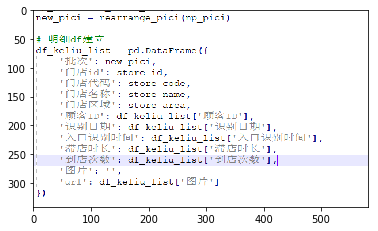

In [116]:
result = reader.readtext('./data/test2.png')
plt.imshow(mpimg.imread('./data/test2.png'))

In [117]:
result

[([[5, 5], [85, 5], [85, 23], [5, 23]], 'nEw pici', 0.1192731261253357),
 ([[114, 5], [207, 5], [207, 25], [114, 25]], 'rearrange', 0.9170975089073181),
 ([[293, 5], [345, 5], [345, 23], [293, 23]], 'pici)', 0.8864076733589172),
 ([[202.65465441200737, 6.520119853208112],
   [254.82601742123165, 2.1841198756198983],
   [256.3453455879926, 20.47988014679189],
   [204.17398257876835, 24.8158801243801]],
  '_pic',
  0.1871252804994583),
 ([[257, 7], [287, 7], [287, 23], [257, 23]], '(IP', 0.2931778132915497),
 ([[22, 38], [128, 38], [128, 62], [22, 62]], '明细df建立', 0.30060186982154846),
 ([[5, 63], [29, 63], [29, 79], [5, 79]], 'cf', 0.1314825862646103),
 ([[35, 63], [137, 63], [137, 79], [35, 79]],
  'keliu list',
  0.26256853342056274),
 ([[195, 63], [307, 63], [307, 79], [195, 79]],
  'Datarrame({',
  0.18860313296318054),
 ([[160.65465441200737, 64.52011985320812],
   [188.54192350325417, 60.72623710600742],
   [190.34534558799263, 78.47988014679188],
   [162.45807649674583, 82.2737628

## 8.80 faker

In [103]:
from faker import Faker
fake = Faker()

fake.name()
# 'Lucy Cechtelar'

fake.address()
# '426 Jordy Lodge
#  Cartwrightshire, SC 88120-6700'

fake.text()

'Age drive lawyer too no while section. If begin hand good. Prevent husband commercial get.\nSeek power guess indicate phone. Crime this husband generation table community.'

In [104]:
for _ in range(10):
    print(fake.name())


Lauren Johnson
William Hunt
Shannon Garcia
Daniel Byrd
Sara Benitez
Debra Ochoa
Joseph Bryant
Glen Reed
Daniel Gonzalez
Todd Allen


In [105]:
from faker import Faker
from faker.providers import internet

fake = Faker()
fake.add_provider(internet)

print(fake.ipv4_private())

192.168.146.217


In [107]:
from faker import Faker
fake = Faker(['zh_CN', 'en_US', 'ja_JP'])
for _ in range(10):
    print(fake.name())

Raymond Aguilar
崔慧
Vincent Serrano
王建军
杨冬梅
Stephanie Farley
Carrie Rivera
村山 涼平
Kevin Parks
John Simpson
